<a href="https://colab.research.google.com/github/thayyilakul/Tensorflow-ML/blob/main/Disaster_texts_prediction_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-12-18 14:00:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-18 14:00:43 (66.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [5]:
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"
unzip_data('nlp_getting_started.zip')

--2024-12-18 14:00:48--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.207, 142.251.183.207, 74.125.201.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2024-12-18 14:00:48 (81.9 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [6]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df_shuffled = train_df.sample(frac = 1, random_state = 42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
train_df.target.value_counts()

,count
target,
0,4342
1,3271


In [10]:
print(f'Total training samples: {len(train_df)}')
print(f'Total test samples: {len(test_df)}')
print(f'Total samples: {len(train_df) + len(test_df)}')

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [11]:
import random
random_index = random.randint(0, len(train_df) - 5)
for row in train_df_shuffled[['text', 'target']][random_index:random_index + 5].itertuples():
  _, text, target = row
  print(f'Target: {target}','(real disaster)' if target > 0 else '(not real disaster)')
  print(f'Text:\n{text}\n')
  print(f'---\n')

Target: 0 (not real disaster)
Text:
i lava you! ????

---

Target: 0 (not real disaster)
Text:
Men fear the feeling of being 'controlled' by a woman. Or passive aggressively being coerced into commitment before they're ready...

---

Target: 1 (real disaster)
Text:
@MichaelWestBiz standard damage control

---

Target: 1 (real disaster)
Text:
E1.1.2 Particulate=Break up of Solid Combust Fossil Fuel Voltaic Active Forest Fire Biological VOC=Petroleum CH4 Bacteria Decomposition

---

Target: 0 (not real disaster)
Text:
and I thought my surgical wounds were healed!!! this weather ain't helping either ):

---



In [12]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size = 0.1,
                                                                            random_state = 42)

In [13]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [15]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = None,
                                    standardize = 'lower_and_strip_punctuation',
                                    split = 'whitespace',
                                    ngrams = None,
                                    output_mode = 'int',
                                    output_sequence_length = None)

In [16]:
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [17]:
max_vocab_length = 10000
max_length = 15
text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length = max_length)

In [18]:
text_vectorizer.adapt(train_sentences)

In [19]:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [20]:
random_sentence = random.choice(train_sentences)
print(f"Original Sentence1:\n{random_sentence}\n\nVectorized version: ")
text_vectorizer([random_sentence])

Original Sentence1:
Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/H84R1TIh8J

Vectorized version: 


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[135,  19, 559,  52, 640,  27,  18,   3, 365,   4, 204,   3, 539,
          1,   0]])>

In [21]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'Top 5 most common words : {top_5_words}')
print(f'Bottom 5 least common words : {bottom_5_words}')

Number of words in vocab: 10000
Top 5 most common words : ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words : ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [22]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length,
                             output_dim = 128,
                             embeddings_initializer = 'uniform',
                             input_length = max_length,
                             name = 'embedding_1')

embedding

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding_1, built=False>

In [23]:
random_sentence = random.choice(train_sentences)
print(f"Original Sentence: \n{random_sentence}\n Embedding:")
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original Sentence: 
Still blazing ????
 Embedding:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02263899,  0.04282571, -0.00747859, ..., -0.01059432,
         -0.0230093 , -0.00547081],
        [-0.01697371,  0.04455257,  0.02342946, ..., -0.00498071,
         -0.02057469, -0.02670168],
        [-0.01314722,  0.02784585,  0.04983481, ...,  0.02798307,
          0.00844678,  0.01084675],
        ...,
        [-0.01314722,  0.02784585,  0.04983481, ...,  0.02798307,
          0.00844678,  0.01084675],
        [-0.01314722,  0.02784585,  0.04983481, ...,  0.02798307,
          0.00844678,  0.01084675],
        [-0.01314722,  0.02784585,  0.04983481, ...,  0.02798307,
          0.00844678,  0.01084675]]], dtype=float32)>

In [24]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.02263899,  0.04282571, -0.00747859,  0.00089192,  0.04500872,
       -0.00142722,  0.04726816,  0.03628168,  0.04347006, -0.04645012,
        0.02594068,  0.00431327, -0.04583221, -0.01125815,  0.00808363,
        0.00415226,  0.04027236, -0.04296472, -0.02459514,  0.02741987,
        0.00120406, -0.03918559,  0.00112037,  0.03599444,  0.01047128,
        0.00643545, -0.02384254, -0.01367823, -0.02450765, -0.01069454,
       -0.0027113 , -0.04961702, -0.03108518, -0.04341054, -0.01487225,
       -0.00901305, -0.02664474, -0.01494026,  0.02640976,  0.02982089,
       -0.01717597,  0.00558516,  0.00045701, -0.02245234, -0.00450317,
       -0.00513272, -0.04660535,  0.01655433,  0.00588652,  0.04959622,
       -0.00338999, -0.02922297, -0.00603061,  0.02842215, -0.03484003,
        0.0075462 , -0.02218043, -0.0495839 , -0.00985516, -0.0460765 ,
        0.0102103 , -0.0208317 , -0.02729491,  0.04335861,  0.02940992,
        0.000462

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f'Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%')

Our baseline model achieves an accuracy of: 79.27%


In [27]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,

In [28]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average = 'weighted')
  model_results = {'accuracy' : model_accuracy,
                   'precision' : model_precision,
                   'recall' : model_recall,
                   'f1' : model_f1}
  return model_results

In [29]:
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [30]:
SAVE_DIR = 'model_logs'

In [31]:
inputs = layers.Input(shape = (1,), dtype = 'string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name = 'model_1_dense')

In [32]:
model_1.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [33]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                       experiment_name = 'simple_dense_model')])

Saving TensorBoard log files to: model_logs/simple_dense_model/20241218-140052
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6330 - loss: 0.6513 - val_accuracy: 0.7598 - val_loss: 0.5343
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8074 - loss: 0.4680 - val_accuracy: 0.7900 - val_loss: 0.4731
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8534 - loss: 0.3634 - val_accuracy: 0.7979 - val_loss: 0.4607
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8866 - loss: 0.2969 - val_accuracy: 0.7900 - val_loss: 0.4666
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9054 - loss: 0.2480 - val_accuracy: 0.7808 - val_loss: 0.4821


In [35]:
model_1.evaluate(val_sentences, val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7690 - loss: 0.5140 


[0.4820725619792938, 0.7808399200439453]

In [36]:
embedding.weights

[<KerasVariable shape=(10000, 128), dtype=float32, path=embedding_1/embeddings>]

In [37]:
embed_weights = model_1.get_layer('embedding_1').get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [38]:
!tensorboard dev upload --logdir ./model_logs \
  --name "First deep model on text data" \
  --description "Trying a dense model with an embedding layer" \
  --one_shot

2024-12-18 14:01:19.442296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 14:01:19.467593: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 14:01:19.474956: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 14:01:20.895270: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.


In [39]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


array([[0.33567098],
       [0.734848  ],
       [0.9978247 ],
       [0.1920529 ],
       [0.1004472 ],
       [0.94609135],
       [0.892815  ],
       [0.9943365 ],
       [0.9609088 ],
       [0.3790033 ]], dtype=float32)

In [40]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [41]:
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'accuracy': 78.08398950131233,
 'precision': 0.7841274438015813,
 'recall': 0.7808398950131233,
 'f1': 0.7782630349987989}

In [42]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [43]:
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f'Baseline {key}:{value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key] - value:.2f}')

compare_baseline_to_new_results(baseline_results = baseline_results,
                                new_model_results = model_1_results)

Baseline accuracy:79.27, New accuracy: 78.08, Difference: -1.18
Baseline precision:0.81, New precision: 0.78, Difference: -0.03
Baseline recall:0.79, New recall: 0.78, Difference: -0.01
Baseline f1:0.79, New f1: 0.78, Difference: -0.01


In [44]:
tf.random.set_seed(42)

model_2_embedding = layers.Embedding(input_dim = max_vocab_length,
                                     output_dim = 128,
                                     embeddings_initializer = 'uniform',
                                     input_length = max_length,
                                     name = 'embedding_2')

inputs = layers.Input(shape = (1, ), dtype = 'string')
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name = 'model_2_LSTM')

(None, 15, 128)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [45]:
model_2.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [46]:
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR, 'LSTM')])

Saving TensorBoard log files to: model_logs/LSTM/20241218-140124
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.6615 - loss: 0.5826 - val_accuracy: 0.7730 - val_loss: 0.4598
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.8654 - loss: 0.3312 - val_accuracy: 0.7572 - val_loss: 0.5034
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9179 - loss: 0.2268 - val_accuracy: 0.7638 - val_loss: 0.6111
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9499 - loss: 0.1512 - val_accuracy: 0.7572 - val_loss: 0.6701
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9648 - loss: 0.1121 - val_accuracy: 0.7625 - val_loss: 0.7284


In [48]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


((762, 1),
 array([[0.02239431],
        [0.97329104],
        [0.9967638 ],
        [0.02221144],
        [0.00301364],
        [0.998816  ],
        [0.25711656],
        [0.9995484 ],
        [0.9987079 ],
        [0.14553355]], dtype=float32))

In [49]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

In [50]:
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 76.24671916010499,
 'precision': 0.7648032381971924,
 'recall': 0.7624671916010499,
 'f1': 0.7598225942829093}

In [51]:
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy:79.27, New accuracy: 76.25, Difference: -3.02
Baseline precision:0.81, New precision: 0.76, Difference: -0.05
Baseline recall:0.79, New recall: 0.76, Difference: -0.03
Baseline f1:0.79, New f1: 0.76, Difference: -0.03


In [52]:
tf.random.set_seed(42)

model_3_embedding = layers.Embedding(input_dim = max_vocab_length,
                           output_dim = 128,
                           embeddings_initializer = 'uniform',
                           input_length = max_length,
                           name = 'embedding_3')

inputs = layers.Input(shape = (1, ), dtype = 'string')
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name = 'model_3_GRU')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [53]:
model_3.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [54]:
model_3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,317,313 (5.03 MB)

 Trainable params: 1,317,313 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR, 'GRU')])

Saving TensorBoard log files to: model_logs/GRU/20241218-140215
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.6557 - loss: 0.6016 - val_accuracy: 0.7756 - val_loss: 0.4590
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.8614 - loss: 0.3361 - val_accuracy: 0.7585 - val_loss: 0.5146
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9105 - loss: 0.2351 - val_accuracy: 0.7585 - val_loss: 0.5911
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.9395 - loss: 0.1744 - val_accuracy: 0.7690 - val_loss: 0.5863
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.9598 - loss: 0.1356 - val_accuracy: 0.7703 - val_loss: 0.6855


In [56]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


array([[0.06221054],
       [0.865408  ],
       [0.99620605],
       [0.11173431],
       [0.01833253],
       [0.9969473 ],
       [0.5050229 ],
       [0.99839437],
       [0.99701047],
       [0.7610251 ]], dtype=float32)

In [57]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [58]:
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 77.03412073490814,
 'precision': 0.7729377683268125,
 'recall': 0.7703412073490814,
 'f1': 0.7677842762403821}

In [59]:
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy:79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision:0.81, New precision: 0.77, Difference: -0.04
Baseline recall:0.79, New recall: 0.77, Difference: -0.02
Baseline f1:0.79, New f1: 0.77, Difference: -0.02


In [60]:
tf.random.set_seed(42)

model_4_embedding = layers.Embedding(input_dim = max_vocab_length,
                                     output_dim = 128,
                                     embeddings_initializer = 'uniform',
                                     input_length = max_length,
                                     name = 'embedding_4')

inputs = layers.Input(shape = (1, ), dtype = 'string')
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name = 'model_4_Bidirectional')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [61]:
model_4.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [62]:
model_4.summary()

Model: "model_4_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR, 'bidirectional_RNN')])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20241218-140329
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.6777 - loss: 0.5795 - val_accuracy: 0.7743 - val_loss: 0.4640
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.8640 - loss: 0.3283 - val_accuracy: 0.7677 - val_loss: 0.5121
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.9156 - loss: 0.2249 - val_accuracy: 0.7585 - val_loss: 0.6009
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.9531 - loss: 0.1417 - val_accuracy: 0.7625 - val_loss: 0.6459
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.9584 - loss: 0.1280 - val_accuracy: 0.7520 - val_loss: 0.7126


In [64]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


array([[0.16713227],
       [0.960741  ],
       [0.9991385 ],
       [0.02801848],
       [0.00812997],
       [0.9801316 ],
       [0.7089253 ],
       [0.999609  ],
       [0.99940246],
       [0.59869516]], dtype=float32)

In [65]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [66]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 75.19685039370079,
 'precision': 0.7527859023002904,
 'recall': 0.7519685039370079,
 'f1': 0.7499245530786587}

In [67]:
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy:79.27, New accuracy: 75.20, Difference: -4.07
Baseline precision:0.81, New precision: 0.75, Difference: -0.06
Baseline recall:0.79, New recall: 0.75, Difference: -0.04
Baseline f1:0.79, New f1: 0.75, Difference: -0.04


In [68]:
embedding_test = embedding(text_vectorizer(['this is a test sentence']))
conv_1d = layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu')
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [69]:
  embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.01484927,  0.04127872, -0.01587925, ..., -0.01223569,
           0.04030773, -0.03100618],
         [ 0.01589073,  0.01932128,  0.09458325, ...,  0.06670943,
          -0.03487351,  0.00687016],
         [ 0.02564662, -0.0163739 , -0.03706221, ...,  0.00995153,
           0.01452322, -0.04313828],
         ...,
         [-0.02927589,  0.04115374,  0.0568382 , ...,  0.03933513,
          -0.00237455,  0.01968056],
         [-0.02927589,  0.04115374,  0.0568382 , ...,  0.03933513,
          -0.00237455,  0.01968056],
         [-0.02927589,  0.04115374,  0.0568382 , ...,  0.03933513,
          -0.00237455,  0.01968056]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.        , 0.        , 0.02493278, 0.0862131 , 0.        ,
          0.01275851, 0.09492323, 0.        , 0.        , 0.09402358,
          0.        , 0.04717013, 0.04926193, 0.03012793, 0.        ,
          0.        , 0.

In [70]:
tf.random.set_seed(42)

model_5_embedding = layers.Embedding(input_dim = max_vocab_length,
                                     output_dim = 128,
                                     embeddings_initializer = 'uniform',
                                     input_length = max_length,
                                     name = 'embedding_5')

inputs = layers.Input(shape = (1, ), dtype = 'string')
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name = 'model_5_Conv1D')

model_5.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

model_5.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_5_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 11, 32)              │          20,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,300,545 (4.96 MB)

 Trainable params: 1,300,545 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR, 'Conv1D')])

Saving TensorBoard log files to: model_logs/Conv1D/20241218-140505
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.6470 - loss: 0.6297 - val_accuracy: 0.7808 - val_loss: 0.4673
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.8471 - loss: 0.3750 - val_accuracy: 0.7874 - val_loss: 0.4732
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9085 - loss: 0.2424 - val_accuracy: 0.7900 - val_loss: 0.5262
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9460 - loss: 0.1584 - val_accuracy: 0.7887 - val_loss: 0.5968
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9636 - loss: 0.1079 - val_accuracy: 0.7861 - val_loss: 0.6627


In [72]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


array([[0.6284408 ],
       [0.8005239 ],
       [0.9995737 ],
       [0.07144935],
       [0.0040465 ],
       [0.99602807],
       [0.9799488 ],
       [0.9992739 ],
       [0.99933875],
       [0.09311576]], dtype=float32)

In [73]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [74]:
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 78.60892388451444,
 'precision': 0.7930934663164497,
 'recall': 0.7860892388451444,
 'f1': 0.7823860842756168}

In [75]:
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy:79.27, New accuracy: 78.61, Difference: -0.66
Baseline precision:0.81, New precision: 0.79, Difference: -0.02
Baseline recall:0.79, New recall: 0.79, Difference: -0.01
Baseline f1:0.79, New f1: 0.78, Difference: -0.00


In [76]:
import tensorflow_hub as hub
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embed_samples = embed([sample_sentence, 'When you call the universal sentence encoder on a sentence, it turns it into numbers.'])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [77]:
embed_samples[0].shape

TensorShape([512])

In [78]:
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape = [],
                                        dtype = tf.string,
                                        trainable = False,
                                        name = 'USE')

In [79]:
import tf_keras

model_6 = tf_keras.Sequential([
  sentence_encoder_layer,
  tf_keras.layers.Dense(64, activation="relu"),
  tf_keras.layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

model_6.compile(loss="binary_crossentropy",
                optimizer='adam',
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [80]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels))
                              # callbacks=[create_tensorboard_callback(SAVE_DIR,
                              #                                        "tf_hub_sentence_encoder")])

Epoch 1/5
215/215 [==============================] - 10s 27ms/step - loss: 0.5085 - accuracy: 0.7776 - val_loss: 0.4508 - val_accuracy: 0.7953
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.4162 - accuracy: 0.8127 - val_loss: 0.4393 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 8s 40ms/step - loss: 0.4018 - accuracy: 0.8203 - val_loss: 0.4349 - val_accuracy: 0.8084
Epoch 4/5
215/215 [==============================] - 5s 25ms/step - loss: 0.3949 - accuracy: 0.8256 - val_loss: 0.4302 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.3890 - accuracy: 0.8278 - val_loss: 0.4316 - val_accuracy: 0.8123


In [81]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 4s 23ms/step


array([[0.14426959],
       [0.7318657 ],
       [0.98428994],
       [0.19073291],
       [0.7479063 ],
       [0.66713846],
       [0.97838247],
       [0.972514  ],
       [0.91854376],
       [0.08700102]], dtype=float32)

In [82]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [83]:
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8145687227271431,
 'recall': 0.8123359580052494,
 'f1': 0.8107894766679798}

In [84]:
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy:79.27, New accuracy: 81.23, Difference: 1.97
Baseline precision:0.81, New precision: 0.81, Difference: 0.00
Baseline recall:0.79, New recall: 0.81, Difference: 0.02
Baseline f1:0.79, New f1: 0.81, Difference: 0.02


In [85]:
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(train_sentences,
                                                                                                                          train_labels,
                                                                                                                          test_size = 0.1,
                                                                                                                          random_state = 42)

In [86]:
print(f'Total training examples: {len(train_sentences)}')
print(f'Length of 10% training examples: {len(train_sentences_10_percent)}')

Total training examples: 6851
Length of 10% training examples: 686


In [87]:
pd.Series(train_labels_10_percent).value_counts()

,count
0,415
1,271


In [88]:
model_7 = tf_keras.models.clone_model(model_6)

model_7.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [89]:
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels))

Epoch 1/5
22/22 [==============================] - 6s 51ms/step - loss: 0.6633 - accuracy: 0.6997 - val_loss: 0.6433 - val_accuracy: 0.6955
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.5875 - accuracy: 0.8047 - val_loss: 0.5844 - val_accuracy: 0.7388
Epoch 3/5
22/22 [==============================] - 1s 28ms/step - loss: 0.5100 - accuracy: 0.8265 - val_loss: 0.5359 - val_accuracy: 0.7690
Epoch 4/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4488 - accuracy: 0.8411 - val_loss: 0.5066 - val_accuracy: 0.7756
Epoch 5/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4076 - accuracy: 0.8411 - val_loss: 0.4902 - val_accuracy: 0.7782


In [90]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 19ms/step


array([[0.24702616],
       [0.78049827],
       [0.88722175],
       [0.28920305],
       [0.5622532 ],
       [0.8083572 ],
       [0.79190683],
       [0.82710123],
       [0.8281    ],
       [0.11172133]], dtype=float32)

In [91]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [92]:
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.82152230971128,
 'precision': 0.7838273596953228,
 'recall': 0.7782152230971129,
 'f1': 0.7747045976528383}

In [93]:
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy:79.27, New accuracy: 77.82, Difference: -1.44
Baseline precision:0.81, New precision: 0.78, Difference: -0.03
Baseline recall:0.79, New recall: 0.78, Difference: -0.01
Baseline f1:0.79, New f1: 0.77, Difference: -0.01


In [94]:
all_model_results = pd.DataFrame({
    'baseline' : baseline_results,
    'simple_dense' : model_1_results,
    'lstm' : model_2_results,
    'gru' : model_3_results,
    'bidirectional' : model_4_results,
    'conv1d' : model_6_results,
    'tf_hub_sentence_encoder' : model_6_results,
    'tf_hub_10_percent_data' : model_7_results,
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.083990,0.784127,0.780840,0.778263
lstm,76.246719,0.764803,0.762467,0.759823
gru,77.034121,0.772938,0.770341,0.767784
bidirectional,75.196850,0.752786,0.751969,0.749925
conv1d,81.233596,0.814569,0.812336,0.810789
tf_hub_sentence_encoder,81.233596,0.814569,0.812336,0.810789
tf_hub_10_percent_data,77.821522,0.783827,0.778215,0.774705


In [95]:
all_model_results['accuracy'] = all_model_results['accuracy'] / 100

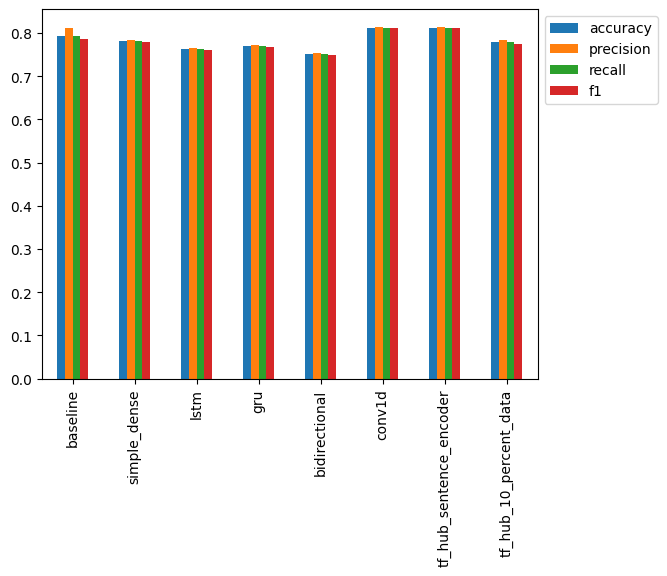

In [96]:
all_model_results.plot(kind = 'bar').legend(bbox_to_anchor = (1.0, 1.0));

<Axes: >

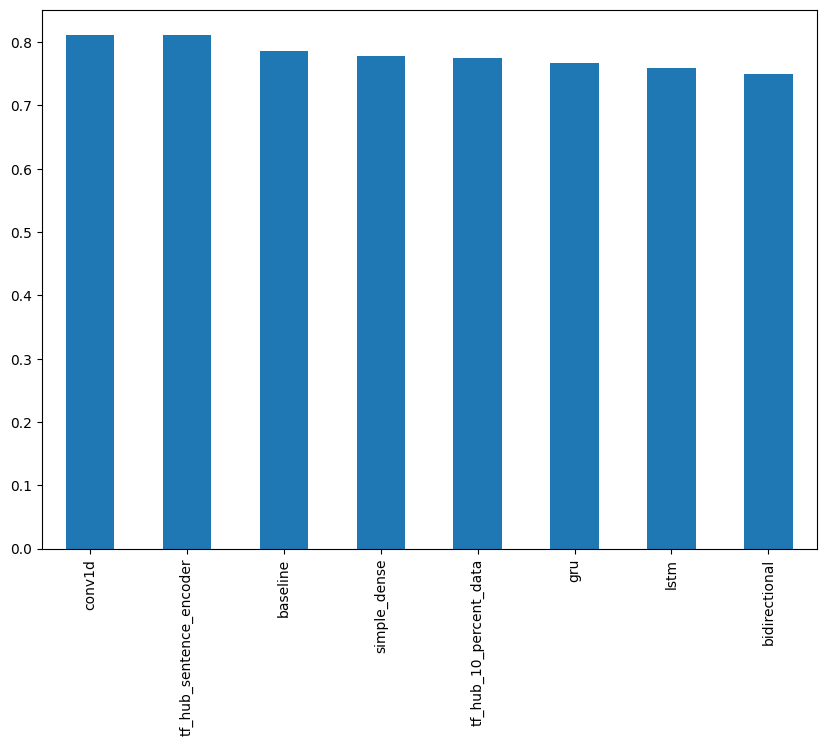

In [97]:
all_model_results.sort_values('f1', ascending = False)['f1'].plot(kind = 'bar', figsize = (10, 7))

In [98]:
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis = 1)
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis = 1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs / 3)
combined_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [99]:
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 79.00262467191601,
 'precision': 0.789737110325998,
 'recall': 0.7900262467191601,
 'f1': 0.7896841842138155}

In [100]:
all_model_results.loc['ensemble_results'] = ensemble_results

In [103]:
all_model_results.loc['ensemble_results']['accuracy'] = all_model_results.loc['ensemble_results']['accuracy']/100

<ipython-input-103-4986557ac854>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_model_results.loc['ensemble_results']['accuracy'] = all_model_results.loc['ensemble_results']['accuracy']/100


In [104]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.780840,0.784127,0.780840,0.778263
lstm,0.762467,0.764803,0.762467,0.759823
gru,0.770341,0.772938,0.770341,0.767784
bidirectional,0.751969,0.752786,0.751969,0.749925
conv1d,0.812336,0.814569,0.812336,0.810789
tf_hub_sentence_encoder,0.812336,0.814569,0.812336,0.810789
tf_hub_10_percent_data,0.778215,0.783827,0.778215,0.774705
ensemble_results,79.002625,0.789737,0.790026,0.789684


In [105]:
model_6.save('model_6.h5')

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [107]:
loaded_model_6 = tf_keras.models.load_model('model_6.h5', custom_objects = {'KerasLayer' : hub.KerasLayer})

In [108]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 12ms/step - loss: 0.4316 - accuracy: 0.8123


[0.4315696954727173, 0.8123359680175781]

In [109]:
model_6.save('model_6_SavedModel_format')

In [111]:
loaded_model_6_SavedModel = tf_keras.models.load_model('model_6_SavedModel_format')

In [112]:
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 18ms/step - loss: 0.4316 - accuracy: 0.8123


[0.4315696954727173, 0.8123359680175781]

In [113]:
val_df = pd.DataFrame({
    'text' : val_sentences,
    'target' : val_labels,
    'pred' : model_6_preds,
    'pred_prob' : tf.squeeze(model_6_pred_probs)
})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.144270
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.731866
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.984290
3,@camilacabello97 Internally and externally scr...,1,0.0,0.190733
4,Radiation emergency #preparedness starts with ...,1,1.0,0.747906


In [114]:
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending = False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.906667
759,FedEx will no longer transport bioterror patho...,0,1.0,0.848571
628,@noah_anyname That's where the concentration c...,0,1.0,0.837095
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.835707
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.833949
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.817409
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.773691
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.773263
144,The Sound of Arson,0,1.0,0.767427
567,@RebeccaforReal accepts Wisconsin Emergency Re...,0,1.0,0.766256


In [115]:
for row in most_wrong[:10].itertuples():
  _, text, target, pred, prob = row
  print(f'Target : {target}, Pred : {pred}, Prob : {prob}')
  print(f'Text:\n{text}\n')
  print('---\n')

Target : 0, Pred : 1.0, Prob : 0.9066672325134277
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

---

Target : 0, Pred : 1.0, Prob : 0.8485706448554993
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

---

Target : 0, Pred : 1.0, Prob : 0.8370948433876038
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

---

Target : 0, Pred : 1.0, Prob : 0.8357065916061401
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

---

Target : 0, Pred : 1.0, Prob : 0.8339487314224243
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

---

Target : 0, Pred : 1.0, Prob : 0.8174088001251221
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

---

In [117]:
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f'Target : {target}, Pred : {pred}, Prob : {prob}')
  print(f'Text:\n{text}\n')
  print('---\n')

Target : 1, Pred : 0.0, Prob : 0.05960942432284355
Text:
'The way you move is like a full on rainstorm and I'm a house of cards'

---

Target : 1, Pred : 0.0, Prob : 0.057065654546022415
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

---

Target : 1, Pred : 0.0, Prob : 0.05468815565109253
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

---

Target : 1, Pred : 0.0, Prob : 0.04879409447312355
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

---

Target : 1, Pred : 0.0, Prob : 0.04730147868394852
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

---

Target : 1, Pred : 0.0, Prob : 0.04103677719831467
Text:
I get to smoke my shit in peace

---

Target : 1, Pred : 0.0, Prob : 0.03794061765074

In [120]:
test_sentences = test_df['text'].tolist()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 114ms/step
Pred: 1, Prob: 0.7329937219619751
Text:
119 Sri Lanka's 'Emergency' Line. 
Busy for the past 30 mins. 
Suppose I need to plan my emergencies better. #SL #RT

----

1/1 [==============================] - 0s 81ms/step
Pred: 0, Prob: 0.24857142567634583
Text:
@OpTic_DKarma dude they demolished you!

----

1/1 [==============================] - 0s 79ms/step
Pred: 1, Prob: 0.6256638765335083
Text:
#Turkey invades #Israel - Halfway to #Armageddon http://t.co/xUOh3sJNXF

----

1/1 [==============================] - 0s 68ms/step
Pred: 0, Prob: 0.22302860021591187
Text:
Permutable site conspiracy up-to-the-minute upheaval: QWkD

----

1/1 [==============================] - 0s 76ms/step
Pred: 0, Prob: 0.05995811149477959
Text:
@ModCloth having some trouble with your site- keep getting this every time I log in? http://t.co/dnKkYiFsvT

----

1/1 [==============================] - 0s 71ms/step
Pred: 0, Prob: 0.040715593844652176
Text:
the bitches

In [121]:
sample_tweet = 'Life like an ensemble: take the best choices from others and make your own'

In [122]:
def predict_on_sentence(model, sentence):
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [123]:
predict_on_sentence(model_6, sample_tweet)

1/1 [==============================] - 0s 253ms/step
Pred: 0.0 (not real disaster) Prob: 0.039919137954711914
Text:
Life like an ensemble: take the best choices from others and make your own


In [124]:
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [125]:
predict_on_sentence(model_6, beirut_tweet_1)

1/1 [==============================] - 0s 175ms/step
Pred: 1.0 (real disaster) Prob: 0.9545288681983948
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [126]:
predict_on_sentence(model_6, beirut_tweet_2)

1/1 [==============================] - 0s 89ms/step
Pred: 1.0 (real disaster) Prob: 0.9663898348808289
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


In [127]:
import time

def pred_timer(model, samples):
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time
  time_per_pred = total_time / len(val_sentences)
  return total_time, time_per_pred

In [128]:
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 17ms/step


(0.841545517999748, 0.001104390443569223)

In [129]:
baseline_model_total_pred_time, baseline_model_time_per_pred = pred_timer(model_0, val_sentences)
baseline_model_total_pred_time, baseline_model_time_per_pred

(0.06668831400020281, 8.751747244121104e-05)

Text(0, 0.5, 'F1 - score')

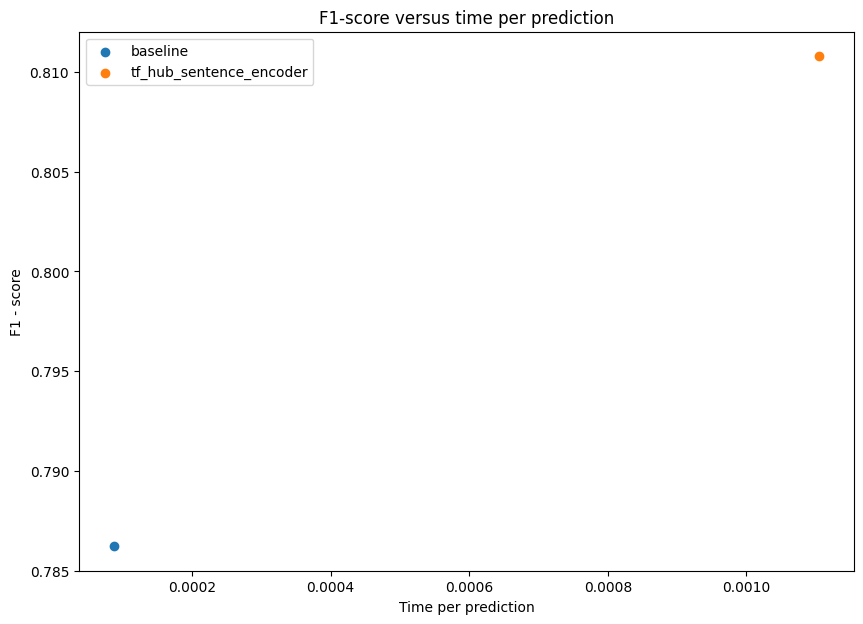

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 7))
plt.scatter(baseline_model_time_per_pred, baseline_results['f1'], label = 'baseline')
plt.scatter(model_6_time_per_pred, model_6_results['f1'], label = 'tf_hub_sentence_encoder')
plt.legend()
plt.title('F1-score versus time per prediction')
plt.xlabel('Time per prediction')
plt.ylabel('F1 - score')